In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
exc = 0.4
inh = 0.322

In [30]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [31]:
dur = 500.
t_pen = 0.96

In [32]:
file_ = '1_E.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = '1'

/high_osc


In [33]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # osc to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [34]:
bestControl_ = None

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]

file found


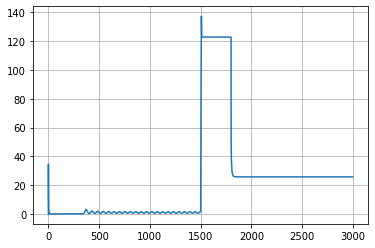

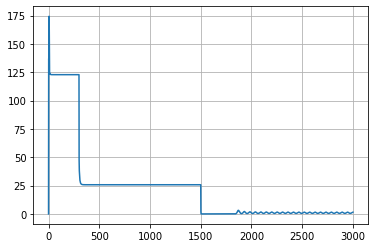

1.5457440477540358
25.73160170281955


In [35]:
# get initial parameters and target states
data.set_parameters(aln)

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = max_I[0])

aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

target_rates = np.zeros((2))
target_rates[0] = aln.rates_exc[0,-1] 
target_rates[1] = aln.rates_inh[0,-1]

control0 = functions.step_control(aln, maxI_ = max_I[1])
aln.run(control=control0)
plt.plot(aln.t, aln.rates_exc[0,:])
plt.show()

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars
target = [target_rates[0], target_rates[1]]

print(initVars[0])
print(target[0])

In [36]:
# get uncontrolled cost
    
aln.params.duration = dur

target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

cost.setParams(wp, 0.0, 0.0)

setinit(initVars, aln)
control0 = aln.getZeroControl()

cgv = None
max_it = 0

bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

cost_uncontrolled = cost_init_[0]

set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  313.59573137650784
RUN  0 , total integrated cost =  313.59573137650784
Gradient descend method:  None
RUN  0 , total integrated cost =  313.59573137650784
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  154.9193338482974
Control only changes marginally.
RUN  1 , total integrated cost =  154.9193338482974
Improved over  1  iterations in  5.632935637026094  seconds by  0.0  percent.


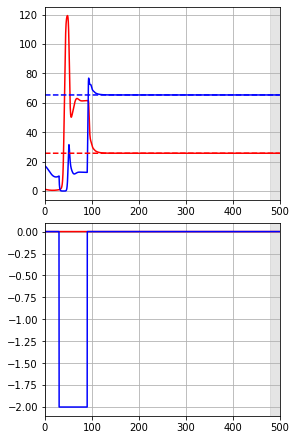

uncontrolled cost :  313.59573137650784
cost splitting :  0.0 [ 0.         15.49193338]


In [37]:
cgv = None
j = 0

aln.params.duration = dur
setinit(initVars, aln)

target_ = aln.getZeroTarget()
target_[:,0,:] = target[0]
target_[:,1,:] = target[1]

control0 = aln.getZeroControl()
cost.setParams(wp, 0., 10.)
max_it = int(10)

control0[0,1,300:900] = -2.

bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
    control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
    startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
    prec_variables_ = p_var, transition_time_ = t_pen)

if True:
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,6) )
    ax[1].plot(plot_time_array, bestControl_[0,0,n_pre-1:-n_post+1], color = 'red')
    ax[0].plot(plot_time_array, bestState_[0,0,n_pre-1:-n_post+1], color= 'red')
    ax[1].plot(plot_time_array, bestControl_[0,1,n_pre-1:-n_post+1], color = 'blue')
    ax[0].plot(plot_time_array, bestState_[0,1,n_pre-1:-n_post+1], color= 'blue')
    ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
    ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

    for k in range(2):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

print('uncontrolled cost : ', cost_uncontrolled)
print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])    

set cost params:  0.05 0.0 143.67457796364675
interpolate adjoint :  True True True
initial cost =  75.98134671017687
RUN  0 , total integrated cost =  75.98134671017687
Gradient descend method:  None
RUN  1 , total integrated cost =  75.98134671017687
Control only changes marginally.
RUN  1 , total integrated cost =  75.98134671017687
Improved over  1  iterations in  0.21417453300091438  seconds by  0.0  percent.
cost splitting :  3.402578243755628e-08 [8.80536580e-13 5.28843361e-01]


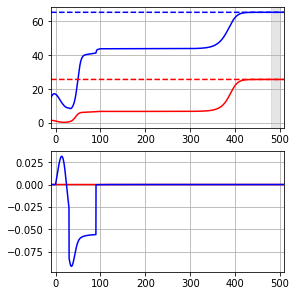

In [24]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-6
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[2] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 203.0848980489481
interpolate adjoint :  True True True
initial cost =  107.40010006545012
RUN  0 , total integrated cost =  107.40010006545012
Gradient descend method:  None
RUN  1 , total integrated cost =  107.40010006545012
Control only changes marginally.
RUN  1 , total integrated cost =  107.40010006545012
Improved over  1  iterations in  0.25483272699057125  seconds by  0.0  percent.
cost splitting :  3.402578243755628e-08 [8.80536580e-13 5.28843361e-01]


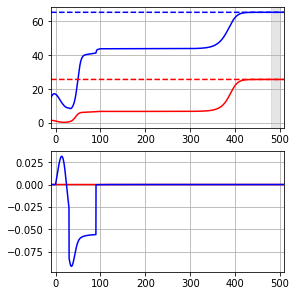

In [25]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-8
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 454.44560346238933
interpolate adjoint :  True True True
initial cost =  240.33054035348857
RUN  0 , total integrated cost =  240.33054035348857
Gradient descend method:  None
RUN  1 , total integrated cost =  240.33054035348857
Control only changes marginally.
RUN  1 , total integrated cost =  240.33054035348857
Improved over  1  iterations in  0.30353394101257436  seconds by  0.0  percent.
cost splitting :  3.402578243755628e-08 [8.80536580e-13 5.28843361e-01]


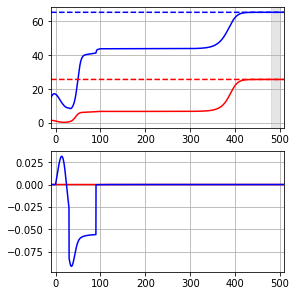

In [26]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-10
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

set cost params:  0.05 0.0 526.4176184880447
interpolate adjoint :  True True True
initial cost =  278.39246268156813
RUN  0 , total integrated cost =  278.39246268156813
Gradient descend method:  None
RUN  1 , total integrated cost =  278.39246266244544
RUN  2 , total integrated cost =  278.39246265353114
RUN  3 , total integrated cost =  278.39246261849405
RUN  4 , total integrated cost =  278.3924626108059
RUN  5 , total integrated cost =  278.39246259056995
RUN  6 , total integrated cost =  277.5981301972918
RUN  7 , total integrated cost =  260.6843418028452
RUN  8 , total integrated cost =  259.8419558574186
RUN  9 , total integrated cost =  259.8353747172198
RUN  10 , total integrated cost =  259.83532636561534
RUN  11 , total integrated cost =  259.83532634097446
RUN  12 , total integrated cost =  259.83532631242764
RUN  13 , total integrated cost =  259.8353262979861
RUN  14 , total integrated cost =  259.8353262979861
Control only changes marginally.
RUN  14 , total integrate

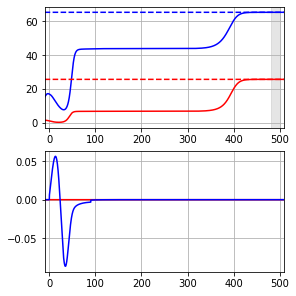

In [27]:
c_var = [0,1]
max_it = int(30)
conv = False

tol = 1e-12
    
while not conv:

    weight_ = random.random() * ( cost_uncontrolled -
                                 costnode_[0][0][0] ) / sum( costnode_[2][0][:] )

    aln.params.duration = dur
    cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
    weights_ = cost.getParams()

    setinit(initVars, aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[0]
    target_[:,1,:] = target[1]

    control0 = aln.getZeroControl()
    control0 = bestControl_[:,:,n_pre-1:-n_post+1]

    bestControl_, bestState_, cost_, runtime_, grad_, phi_, phi1_, costnode_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if cost_[3] == 0.:
        conv = True

    #print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[0][0][0], costnode_[2][0][:2])

    if conv and True:
        time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0]
        target_[:,1,:] = target[1]

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
        ax[1].plot(time_, bestControl_[0,0,:], color = 'red')
        ax[0].plot(time_, bestState_[0,0,:], color= 'red')
        ax[1].plot(time_, bestControl_[0,1,:], color = 'blue')
        ax[0].plot(time_, bestState_[0,1,:], color= 'blue')
        ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
        ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
        ax[0].set_xlim(-dur_pre,dur+dur_post)
        ax[1].set_xlim(-dur_pre,dur+dur_post)
        ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    with open(file_,'wb') as f:
        pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)